 - __Import base modules__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

 - __Import sklearn modules__

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import recall_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


 - __Import the IMDB movie review dataset__
 - Data Link : https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?select=IMDB+Dataset.csv

In [3]:
dataset = pd.read_csv("IMDBDataset.csv", header=0, index_col=None)
dataset.head(2)
dataset.isnull().sum()

review       0
sentiment    0
dtype: int64

 - __Check proportion of class values__

In [4]:
dataset.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

 - __Check if NaN values are there and if yes then collect row indices__

In [5]:
blanks = []
for index, label, review in dataset.itertuples():
    if type(review)==str:
        if review.isspace():
            blanks.append(index)
        
print(len(blanks), 'blanks: ', blanks)

0 blanks:  []


 - __Use Beautiful soup to remove html tags__
 - __Use regex to replace "__< br / >__" with blanks__
 - __Use regex to replace special characters with blanks__
 - __Split each word of a row__
 - __Perform stopword checklist__
 - __Rejoin the set of words for each row__
 - __Append the clean set of text in a list__

In [6]:
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from tqdm import tqdm_notebook
from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Debjani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
clean_text = []
for i in tqdm(range(dataset.shape[0])):
    soup = BeautifulSoup(dataset['review'].loc[i], "html.parser")
    text = soup.get_text()
    text = re.sub('\<br />', '', text)
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    text = text.lower()
    text = text.split()
    text = [word for word in text if not word in set(stopwords.words('english'))]
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text]
    text = ' '.join(text)
    clean_text.append(text)

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [32:57<00:00, 25.29it/s]


In [8]:
df_processed = pd.DataFrame(clean_text,columns=['review_processed'])
dataset_new = pd.concat([dataset, df_processed], axis=1)
dataset_new.drop(labels=['review'], inplace=True, axis=1)
dataset_new.head(2)

,sentiment,review_processed
0,positive,one reviewer mentioned watching 1 oz episode y...
1,positive,wonderful little production filming technique ...


 - __Download google word2vec pre trained model from gensim__

In [9]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

 - __Create unique set of words from google model__

In [10]:
vocabulary = set(wv.index2word)

 - __Dimension of each word__

In [11]:
embedding_size = wv.vector_size

In [12]:
print("Model contains %d words" %len(vocabulary))

Model contains 3000000 words


In [13]:
print("Each word is represented by a %d dimensional vector" %embedding_size)

Each word is represented by a 300 dimensional vector


 - __Create X and y attrs__

In [14]:
X, y = dataset_new['review_processed'], dataset_new['sentiment']
sdict = {'positive': 1, 'negative': 0}
y = y.map(sdict)
X.shape, y.shape

((50000,), (50000,))

In [15]:
print('Number of messages = %d.' %len(X))
print('Number of labels = %d.' %len(y))

Number of messages = 50000.
Number of labels = 50000.


In [16]:
print("Number of missing messages: %d." %(np.sum(pd.isnull(X))))
print("Number of distinct messages = %d" %(dataset_new.review_processed.nunique()))

Number of missing messages: 0.
Number of distinct messages = 49578


 - __Define word2vec function where mean of the vectors would be considered if the word exists__
 - __Else zero__

In [17]:
def mean_vector(review):
    zero = np.zeros((embedding_size,), dtype="float32")
    if pd.isnull(review):
        return zero
    words = [w for w in review.split() if w in vocabulary]
    if not words:
        return zero
    return np.mean([wv[w] for w in words], axis=0)

In [18]:
cols = ['v_'+str(i) for i in range(embedding_size)]

In [19]:
dfV = pd.DataFrame(list(map(mean_vector, X)), columns=cols)

In [20]:
dfV.insert(0, 'target', dataset['sentiment'])

In [21]:
print('Representation has %d rows and %d columns' %dfV.shape)

Representation has 50000 rows and 301 columns


In [22]:
X = dfV.drop(labels='target', axis=1)
y = dfV.target
y = y.map(sdict)
X.shape, y.shape

((50000, 300), (50000,))

 - __Create training and testing datasets__

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35000, 300), (15000, 300), (35000,), (15000,))

In [24]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 17500
Before OverSampling, counts of label '0': 17500 



 - __Apply scaling before Neural operations__

In [25]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train.shape, X_test.shape

((35000, 300), (15000, 300))

 - __Perform a basic Auto Neural Network model__
 - __input dimensions are 300 as there are those many columns from word2vec model__
 - __Choosing 150 neurons approximately, about half of input dimensions__
 - __Choosing gradient descent adam optimizer with binary cross entropy as loss because of binary classification__
 - __Dropping 10% of neurons from fully connected layers__
 - __Choosing sigmoid function for back propagation__
 - __Choosing reactive for forward propagation__

In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier

In [27]:
classifier = Sequential()

classifier.add(Dense(units=150, kernel_initializer='uniform', activation='relu', input_dim=300))
classifier.add(Dropout(rate=0.1))

classifier.add(Dense(units=150, kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(rate=0.1))

classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

classifier.fit(X_train, y_train, batch_size=25, epochs=500)

Epoch 1/500
35000/35000 [==============================] - 4s 101us/step - loss: 0.3586 - accuracy: 0.8465
Epoch 2/500
35000/35000 [==============================] - 3s 85us/step - loss: 0.3240 - accuracy: 0.8642
Epoch 3/500
35000/35000 [==============================] - 3s 84us/step - loss: 0.3071 - accuracy: 0.8716
Epoch 4/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.2904 - accuracy: 0.8757
Epoch 5/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.2725 - accuracy: 0.8837
Epoch 6/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.2548 - accuracy: 0.8898
Epoch 7/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.2358 - accuracy: 0.8955
Epoch 8/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.2212 - accuracy: 0.9030
Epoch 9/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.2032 - accuracy: 0.9106
Epoch 10/500
35000/35000 [===================

35000/35000 [==============================] - 3s 73us/step - loss: 0.0322 - accuracy: 0.9889
Epoch 78/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0332 - accuracy: 0.9885
Epoch 79/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0363 - accuracy: 0.9880
Epoch 80/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0332 - accuracy: 0.9890
Epoch 81/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0333 - accuracy: 0.9891
Epoch 82/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0351 - accuracy: 0.9886
Epoch 83/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0323 - accuracy: 0.9893
Epoch 84/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0311 - accuracy: 0.9901
Epoch 85/500
35000/35000 [==============================] - 3s 75us/step - loss: 0.0319 - accuracy: 0.9887
Epoch 86/500
35000/35000 [========================

35000/35000 [==============================] - 3s 73us/step - loss: 0.0255 - accuracy: 0.9926
Epoch 154/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0209 - accuracy: 0.9933
Epoch 155/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0222 - accuracy: 0.9925
Epoch 156/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0255 - accuracy: 0.9919
Epoch 157/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0205 - accuracy: 0.9930
Epoch 158/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0202 - accuracy: 0.9939
Epoch 159/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0240 - accuracy: 0.9924
Epoch 160/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0209 - accuracy: 0.9933
Epoch 161/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0197 - accuracy: 0.9933
Epoch 162/500
35000/35000 [===============

Epoch 229/500
35000/35000 [==============================] - 3s 72us/step - loss: 0.0184 - accuracy: 0.9942
Epoch 230/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0183 - accuracy: 0.9941
Epoch 231/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0177 - accuracy: 0.9944
Epoch 232/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0165 - accuracy: 0.9952
Epoch 233/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0193 - accuracy: 0.9937
Epoch 234/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0184 - accuracy: 0.9941
Epoch 235/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0170 - accuracy: 0.9944
Epoch 236/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0178 - accuracy: 0.9939
Epoch 237/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0167 - accuracy: 0.9945
Epoch 238/500
35000/35000 [=

35000/35000 [==============================] - 3s 74us/step - loss: 0.0147 - accuracy: 0.9955
Epoch 305/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0170 - accuracy: 0.9949
Epoch 306/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0162 - accuracy: 0.9949
Epoch 307/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0166 - accuracy: 0.9945
Epoch 308/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0131 - accuracy: 0.9956
Epoch 309/500
35000/35000 [==============================] - 3s 75us/step - loss: 0.0174 - accuracy: 0.9947
Epoch 310/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0174 - accuracy: 0.9946
Epoch 311/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0157 - accuracy: 0.9955
Epoch 312/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0142 - accuracy: 0.9956
Epoch 313/500
35000/35000 [===============

Epoch 380/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0128 - accuracy: 0.9956
Epoch 381/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0134 - accuracy: 0.9957
Epoch 382/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0173 - accuracy: 0.9954
Epoch 383/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0148 - accuracy: 0.9951
Epoch 384/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0130 - accuracy: 0.9958
Epoch 385/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0134 - accuracy: 0.9957
Epoch 386/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0127 - accuracy: 0.9964
Epoch 387/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0114 - accuracy: 0.9964
Epoch 388/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0167 - accuracy: 0.9953
Epoch 389/500
35000/35000 [=

35000/35000 [==============================] - 3s 73us/step - loss: 0.0146 - accuracy: 0.9956
Epoch 456/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0140 - accuracy: 0.9961
Epoch 457/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0143 - accuracy: 0.9956
Epoch 458/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0116 - accuracy: 0.9967
Epoch 459/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0136 - accuracy: 0.9957
Epoch 460/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0130 - accuracy: 0.9962
Epoch 461/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0132 - accuracy: 0.9963
Epoch 462/500
35000/35000 [==============================] - 3s 73us/step - loss: 0.0104 - accuracy: 0.9965
Epoch 463/500
35000/35000 [==============================] - 3s 74us/step - loss: 0.0139 - accuracy: 0.9961
Epoch 464/500
35000/35000 [===============

In [28]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

The accuracy score for the model is: 0.848
The recall score for the model is: 0.848
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      7500
           1       0.85      0.84      0.85      7500

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



Text(91.68, 0.5, 'Actual')

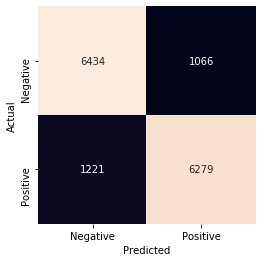

In [29]:
acc = round(accuracy_score(y_test, y_pred),3)
rec = round(recall_score(y_test, y_pred, average="macro"), 3)
cre = classification_report(y_test,y_pred)
print("The accuracy score for the model is: {}".format(acc))
print("The recall score for the model is: {}".format(rec))
print(cre)
met = confusion_matrix(y_test, y_pred)
sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")